In [1]:
import pathlib

# umap analysis of treatment groups
# using warnings to ignore the deprecation warnings upon importing umap and numba
# these are annoying and not useful for the analysis output
import warnings

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import umap
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/lippincm/miniconda3/envs/Interstellar/lib/pyth

In [2]:
# set the path of import files
cytokines_path = pathlib.Path("./results/cytokines.csv")
filtered_path = pathlib.Path(
    "../../Data/filtered/nELISA_plate_430420_no_inhibitors.csv"
)
# import data
cytokines = pd.read_csv(cytokines_path)

df = pd.read_csv(filtered_path)

In [3]:
# remove from Inducer1_and_dose column from df if it contains 'Topotecan'
df = df[~df["Inducer1_and_dose"].str.contains("Topotecan")]

In [4]:
# convert cytokines to a list
cytokines_list = cytokines["cytokine"].tolist()
# subset the filtered_df with cytokines_list
df_cytokine = df[cytokines_list]

In [5]:
# reorder the treatment list
# this for the purpose of plotting in a specific order on the x axis
treatment_order_lst = [
    "DMSO_0.10%",
    "Disulfiram_0.1 µM",
    "Disulfiram_1 µM",
    "Disulfiram_2.5 µM",
    "Flagellin_0.1 µg/ml",
    "Flagellin_1 µg/ml",
    "LPS_0.01 µg/ml",
    "LPS_0.1 µg/ml",
    "LPS_1 µg/ml",
    "LPS_10 µg/ml",
    "LPS_100 µg/ml",
    "Thapsigargin_1 µM",
    "Thapsigargin_10 µM",
    "H2O2_100 nM",
    "H2O2_100 µM",
]

### UMAP of selected cytokines across all treatments
The cytokines were selected from the previous notebook.  
Each cytokine was selected via ANOVA and post-hoc tests followed by a manual selection of cytokines that differed between pyroptotic and apoptotic treatments.

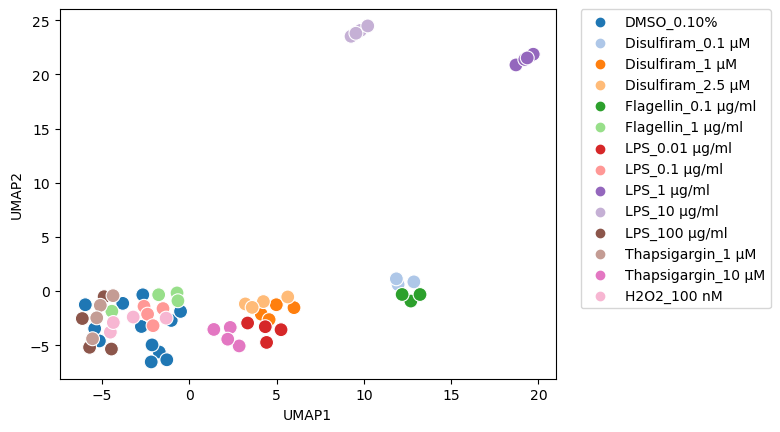

In [6]:
# define the reducer
reducer = umap.UMAP(n_neighbors=4, min_dist=1, random_state=42)
# fit the reducer
embedding = reducer.fit_transform(df_cytokine)
# create a dataframe from the embedding
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
# add the treatment groups to the embedding df
embedding_df["Inducer1_and_dose"] = df["Inducer1_and_dose"]
# plot the embedding
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=embedding_df,
    hue="Inducer1_and_dose",
    palette="tab20",
    s=100,
)

# get the handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
# create a dictionary to map the labels to the treatments
label_dict = dict(zip(labels, treatment_order_lst))
# map the labels to the treatments
labels = [label_dict[label] for label in labels]
# create a new legend
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# show the plot
plt.show()

### UMAP of selected cytokines across selected treatments
Here we show the UMAP of the selected cytokines across the selected treatments: DMSO, LPS, and Thapsigargin.  
These treatments were selected to show Control, Pyroptosis and Apoptosis respectively.

In [7]:
# set the treatments to plot
treatment_lst = [
    "DMSO_0.10%",
    "LPS_100 µg/ml",
    "Thapsigargin_10 µM",
]

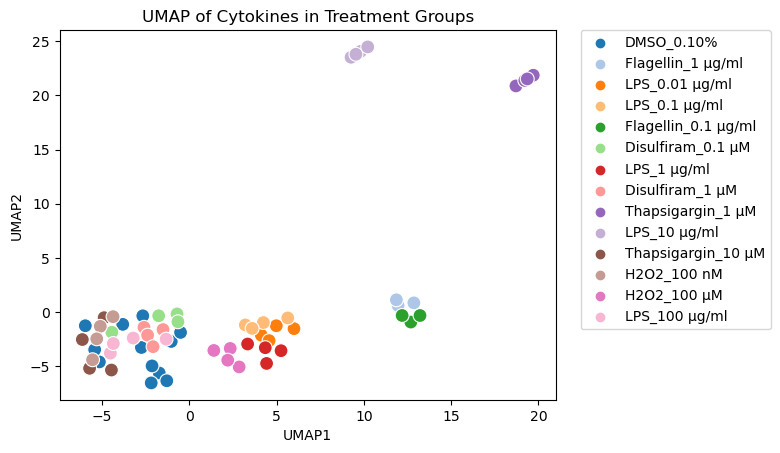

In [8]:
# subset df by treatment_lst in Inducer1_and_dose column
df_treatment = df[df["Inducer1_and_dose"].isin(treatment_lst)]
df_treatment = df_treatment.reset_index(drop=True)

# get the columns to umap with columns that contain '[NSU]'
column_list = [col for col in df_treatment.columns if "[NSU]" in col]
# subset columns in df from column_list
df_cytokine = df_treatment[column_list]
treatment_col = df_treatment["Inducer1_and_dose"]

# plot the embedding
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=embedding_df,
    hue="Inducer1_and_dose",
    palette="tab20",
    s=100,
)
plt.title("UMAP of Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

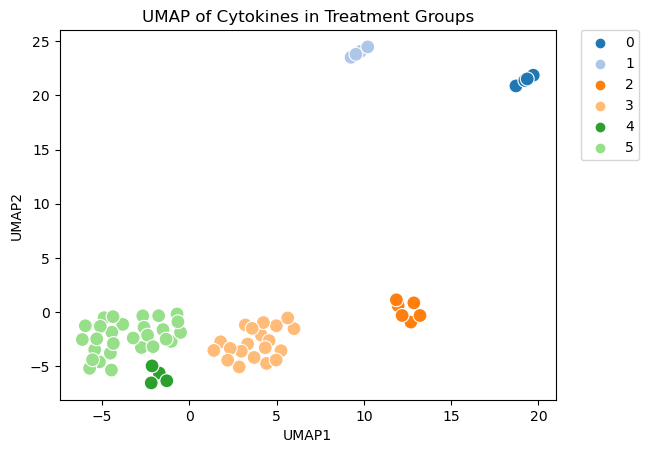

In [9]:
# get cluster labels
cluster = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1).fit_predict(
    embedding_df[["UMAP1", "UMAP2"]]
)
# add the cluster labels to the embedding df
embedding_df["cluster"] = cluster
# plot the embedding
sns.scatterplot(
    x="UMAP1", y="UMAP2", data=embedding_df, hue="cluster", palette="tab20", s=100
)
plt.title("UMAP of Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

Here we do the same as above but with more treatment groups:
- DMSO : Control
- LPS 10ng/ml : Pyroptosis
- LPS 100ng/ml : Pyroptosis
- Thapsigargin 1uM : Apoptosis
- Thapsigargin 10uM : Apoptosis
- H202 10nM : General Cell Stress
- H202 10uM : General Cell Stress

We expect to see clear seperations between LPs and Thapsigargin treatments.

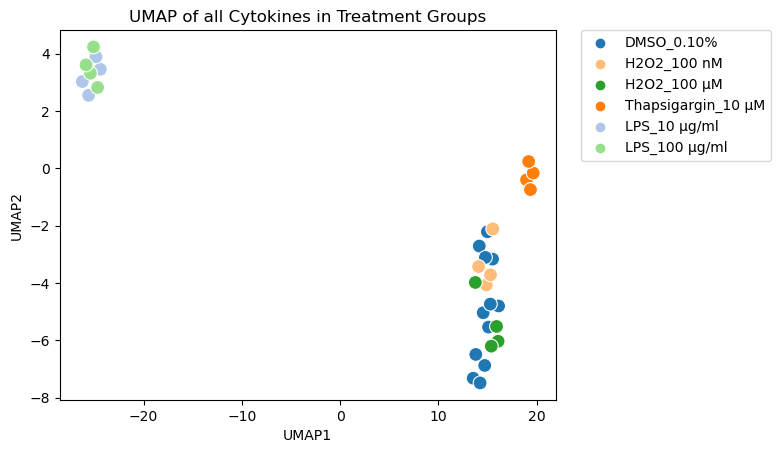

In [10]:
# umap of all cytokines in three treatment groups
# subset df by treatment_lst in Inducer1_and_dose column
treatment_lst = [
    "DMSO_0.10%",
    "H2O2_100 nM",
    "H2O2_100 µM",
    "Thapsigargin_10 µM",
    "LPS_10 µg/ml",
    "LPS_100 µg/ml",
]
df_treatment = df[df["Inducer1_and_dose"].isin(treatment_lst)]
df_treatment = df_treatment.reset_index(drop=True)

# get the columns to umap with columns that contain '[NSU]'
column_list = [col for col in df_treatment.columns if "[NSU]" in col]
# subset columns in df from column_list
df_cytokine = df_treatment[column_list]
treatment_col = df_treatment["Inducer1_and_dose"]

# umap of df_cytokine
# define the reducer
reducer = umap.UMAP(n_neighbors=5, min_dist=0.5, random_state=42)
# fit the reducer
embedding = reducer.fit_transform(df_cytokine)
# create a dataframe from the embedding
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
# add the treatment groups to the embedding df
embedding_df["Inducer1_and_dose"] = treatment_col
# plot the embedding
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    data=embedding_df,
    hue="Inducer1_and_dose",
    palette="tab20",
    s=100,
)
plt.title("UMAP of all Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# order the legend by treatment_lst and move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# order the legend by treatment_lst
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(treatment) for treatment in treatment_lst]
plt.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.0,
)
plt.show()

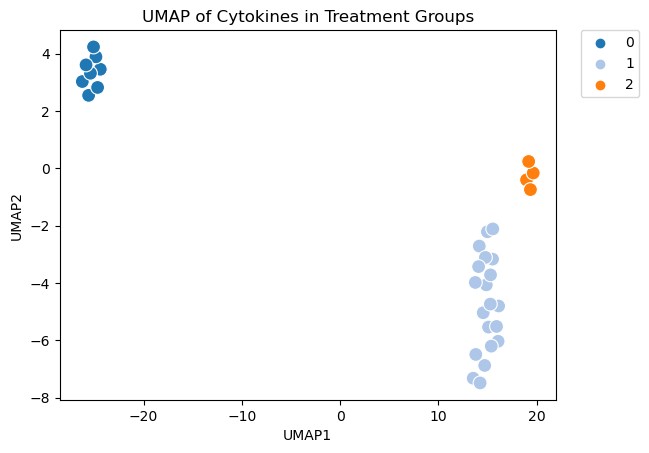

In [11]:
# label the clusters
cluster = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1).fit_predict(
    embedding_df[["UMAP1", "UMAP2"]]
)
# add the cluster labels to the embedding df
embedding_df["cluster"] = cluster
# plot the embedding
sns.scatterplot(
    x="UMAP1", y="UMAP2", data=embedding_df, hue="cluster", palette="tab20", s=100
)
plt.title("UMAP of Cytokines in Treatment Groups")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

Based on these clustering, it seems that the selected cytokines are enough to seperate the treatments.  
We can see that the LPS treatments are seperated from the Thapsigargin treatments.  
The variability of cytokine levels in enought to seperate the treatments. We can move forward with further investigation of these cytokines.